In [1]:
using SparseArrays, PyPlot, Polynomials

In [22]:
function channelFlow(L, B, H, n)
    A = sqrt(1/4 * (L-B)^2 - H^2)
    h = 1.0 / n
    N = (n+1)^2
    xi = h * (0:n)
    eta = xi

    J(i, j) = B*H/2 + A*H*eta[j]
    a(i, j) = (A*xi[i])^2 + H^2
    b(i, j) = (B/2 + A*eta[j]) * A*xi[i]
    c(i, j) = (B/2 + A*eta[j])^2
    e(i, j) = 2*A*H / J(i, j)

    umap = reshape(1:N, n+1, n+1)     # Index mapping from 2D grid to vector
    Q = Tuple{Int64,Int64,Float64}[]  # Array of matrix elements (row,col,value)
    rhs = zeros(N)

    # Main loop, insert stencil in matrix for each node point
    for j = 1:n+1
        for i = 1:n+1
            row = umap[i,j]
            if i == n+1 || j == 1 
                # Dirichlet boundary condition, u = g
                push!(Q, (row, row, 1.0))
                rhs[row] = 0
            elseif i == 1
                # Neumann, left boundary
                push!(Q, (row, row, -1.5))
                push!(Q, (row, umap[2, j], 2.0))
                push!(Q, (row, umap[3, j], -0.5))
                rhs[row] = 0
            elseif j == n+1
                # Neumann, top boundary
                push!(Q, (row, row, 1.5 * (B/2 + A)))
                push!(Q, (row, umap[i, n], -2.0 * (B/2 + A)))
                push!(Q, (row, umap[i, n-1], 0.5 * (B/2 + A)))
                push!(Q, (row, umap[i+1, n+1], -A*xi[i]/2))
                push!(Q, (row, umap[i-1, n+1], A*xi[i]/2))
                rhs[row] = 0
            else
                # Interior nodes, 9-point stencil
                push!(Q, (row, row, -2 * a(i, j) - 2 * c(i,j)))
                push!(Q, (row, umap[i-1,j], a(i,j) - h*e(i,j)/2))
                push!(Q, (row, umap[i+1,j], a(i,j) + h*e(i,j)/2))
                push!(Q, (row, umap[i,j+1], c(i,j)))
                push!(Q, (row, umap[i,j-1], c(i,j)))
                push!(Q, (row, umap[i-1,j-1], -b(i,j)/2))
                push!(Q, (row, umap[i-1,j+1], b(i,j)/2))
                push!(Q, (row, umap[i+1,j-1], b(i,j)/2))
                push!(Q, (row, umap[i+1,j+1], -b(i,j)/2))
 
                rhs[row] = -(J(i,j) * h)^2
            end
        end
    end

    # Create CSC sparse matrix from matrix elements
    Q = sparse((x->x[1]).(Q), (x->x[2]).(Q), (x->x[3]).(Q), N, N)

    u = Q \ rhs
    
    # Convert back to x, y
    tox(xi, eta) = (B/2 .+ A .* eta) .* xi
    toy(xi, eta) = H * eta

    xis = repeat(xi, n+1)
    etas = repeat(eta, inner=n+1)

    x = tox(xis, etas)
    y = toy(xis, etas)

    return Q, x, y, u
end

channelFlow (generic function with 1 method)

0.75


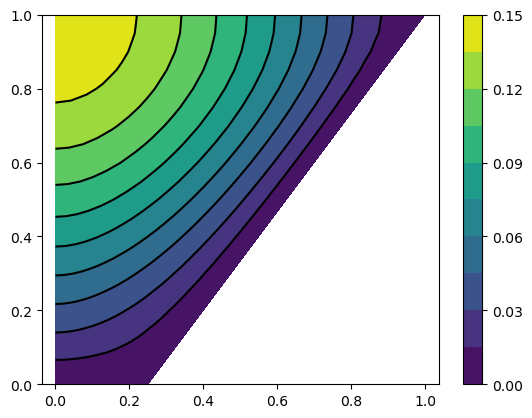

In [23]:
L = 3.0
B = 0.5
H = 1.0

function plotFlow(L, B, H, n)
    h = 1/n
    N = (n+1)^2
    A = sqrt(1/4 * (L-B)^2 - H^2)
    println(A)

    Q, x, y, u = channelFlow(L, B, H, n)


    fig, ax = subplots()
    ax.tricontour(x, y, u, levels = 10, colors ="k")
    pcm = ax.tricontourf(x, y, u, levels=10)
    axis("equal")
    fig.colorbar(pcm, ax=ax)

    return fig, ax, u
end

clf()
n=20
fig, ax, u = plotFlow(L, B, H, n)
gcf()

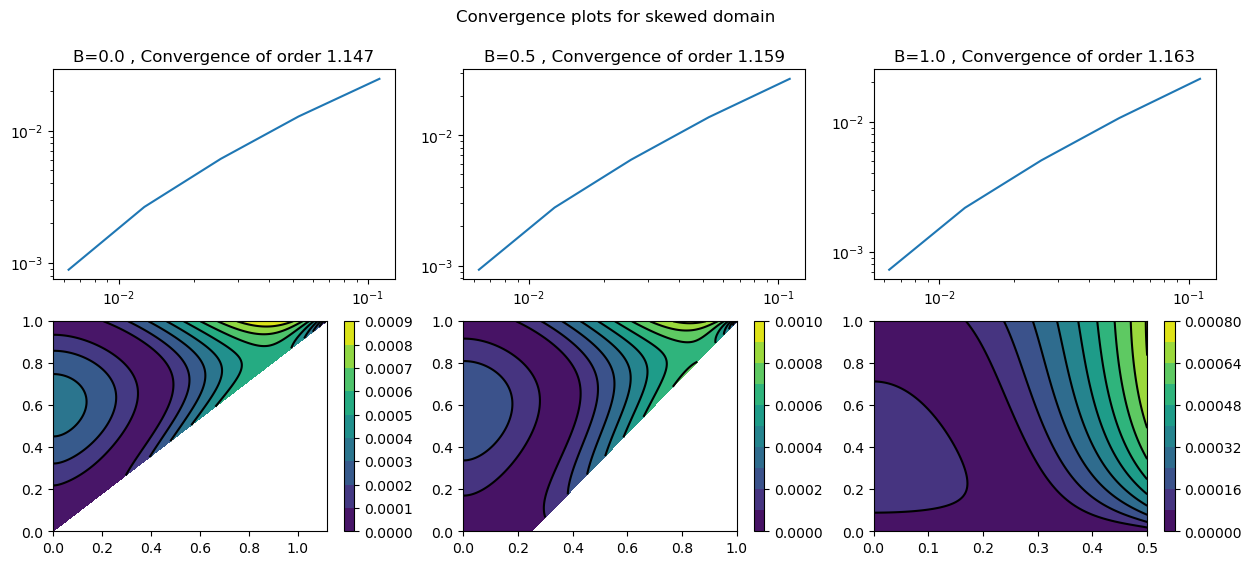

In [25]:
L = 3.0
H = 1.0
ns = [9, 19, 39, 79, 159]
Bs = [0.0, 0.5, 1.0]

clf()
fig, axs = subplots(2,3, figsize=(15,6))
fig.suptitle("Convergence plots for skewed domain")


for j = (1:3)
    Q, x, y, uexact = channelFlow(L, Bs[j], H, 319)
    uexact = reshape(uexact, 320, 320)
    
    errors = zeros(length(ns))
    hs = 1 ./ ns
    for i in (1:length(ns))
        n = ns[i]
        Q, x, y, u = channelFlow(L, Bs[j], H, n)
        u = reshape(u, n+1, n+1)
        step = trunc(Int64,(320/(n+1)))
        difference = abs.(u - uexact[begin:step:end, begin:step:end])
  
        errors[i] = maximum([maximum(difference), errors[i]])

        # Plot difference for n = 159
        if i == length(ns)
            difference = reshape(difference, (n+1)^2)
            axs[2,j].tricontour(x, y, difference, levels=10, colors ="k")
            pcm = axs[2,j].tricontourf(x, y, difference, levels=10)
            fig.colorbar(pcm, ax=axs[2,j])
        end
    end
    fit = Polynomials.fit(log.(hs), log.(errors), 1)
    order = coeffs(fit)[2]

    axs[1,j].set_title("B=$(Bs[j]) , Convergence of order $(round(order,digits=3))")
    axs[1,j].loglog(hs, errors)
end

gcf()